# Двухуровневые модели рекомендаций


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('raw_data/retail_train.csv')
item_features = pd.read_csv('raw_data/product.csv')
user_features = pd.read_csv('raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=5)

[871756, 1044078, 899624, 12262978, 8090537]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 823990, 1078652, 15778319]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[974265, 1107760, 9245108, 5707857, 1102003]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

Топ-50 персональных рекомендаций

In [11]:
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
res = pd.merge(users_lvl_2, result_lvl_1, on='user_id', how='left')
res.head(2)

,user_id,candidates,actual
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944...","[1019940, 834103, 918438, 878302, 949616, 9879..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102...","[840361, 856060, 869344, 896862, 951590, 10191..."


In [12]:
res.apply(lambda row: recall_at_k(row['candidates'], row['actual'], k=50), axis=1).mean()

0.06525657038145175

50 рекомендаций ALS

In [13]:
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
res = pd.merge(users_lvl_2, result_lvl_1, on='user_id', how='left')
res.head(2)

,user_id,candidates,actual
0,2070,"[917033, 1029743, 1016800, 1050741, 1056509, 9...","[1019940, 834103, 918438, 878302, 949616, 9879..."
1,2021,"[8090537, 895166, 841220, 989069, 1106116, 950...","[840361, 856060, 869344, 896862, 951590, 10191..."


In [14]:
res.apply(lambda row: recall_at_k(row['candidates'], row['actual'], k=50), axis=1).mean()

0.04909066127150921

50 похожих товаров

In [15]:
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
res = pd.merge(users_lvl_2, result_lvl_1, on='user_id', how='left')
res.head(2)

,user_id,candidates,actual
0,2070,"[1074754, 834117, 950202, 1044078, 857215, 101...","[1019940, 834103, 918438, 878302, 949616, 9879..."
1,2021,"[846550, 952563, 1004906, 13512542, 12301100, ...","[840361, 856060, 869344, 896862, 951590, 10191..."


In [16]:
res.apply(lambda row: recall_at_k(row['candidates'], row['actual'], k=50), axis=1).mean()

0.03360930816576133

Комбинация из этих методов

In [17]:
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_pers_recommendation(x, N=50))
res = pd.merge(users_lvl_2, result_lvl_1, on='user_id', how='left')
res.head(2)

,user_id,candidates,actual
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944...","[1019940, 834103, 918438, 878302, 949616, 9879..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102...","[840361, 856060, 869344, 896862, 951590, 10191..."


In [18]:
res.apply(lambda row: recall_at_k(row['candidates'], row['actual'], k=50), axis=1).mean()

0.07049003139631092

In [19]:
recall_list =[]
for k in [50, 100, 200, 250, 300, 500]:
    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_pers_recommendation(x, N=k))
    res = pd.merge(users_lvl_2, result_lvl_1, on='user_id', how='left')
    
    recall_list.append(res.apply(lambda row: recall_at_k(row['candidates'], row['actual'], k=k), axis=1).mean())

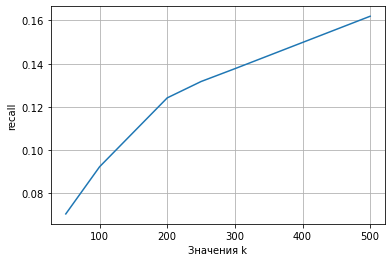

In [20]:
plt.plot([50, 100, 200, 250, 300, 500], recall_list)

plt.xlabel('Значения k')
plt.ylabel('recall')

#plt.ylim(0.07, 0.072)

plt.grid()

С увеличением $k$ $recall$ увеличивается. Но увеличение $k$ будет усложнять модель $2$ уровня. Остановимся на $k=200$.

In [21]:
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_pers_recommendation(x, N=200))
res = pd.merge(users_lvl_2, result_lvl_1, on='user_id', how='left')
res.head(2)

,user_id,candidates,actual
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944...","[1019940, 834103, 918438, 878302, 949616, 9879..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102...","[840361, 856060, 869344, 896862, 951590, 10191..."


In [22]:
res.apply(lambda row: recall_at_k(row['candidates'], row['actual'], k=200), axis=1).mean()

0.12418085535267799

Измерьте отдельно precision@5 модели 1-ого уровня

In [23]:
result_lvl_3 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_3.columns=['user_id', 'actual']
result_lvl_3.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [24]:
users_lvl_3 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_3.columns = ['user_id']

In [25]:
len(set(train_users) -set(users_lvl_3['user_id'].unique()))

344

Правда не уверена, что правильно обошла 344 новых пользователей

In [26]:
users_lvl_3['candidates'] = users_lvl_3['user_id'].apply(lambda x: recommender.get_pers_recommendation(x, N=200))
res_3 = pd.merge(users_lvl_3, result_lvl_3, on='user_id', how='left')
res_3.head(2)

,user_id,candidates,actual
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944...","[834103, 982386, 1039840, 878302, 1080414, 825..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102...","[885655, 951590, 13504479, 856060, 870933, 981..."


In [27]:
res_3.apply(lambda row: precision_at_k(row['candidates'], row['actual'], k=5), axis=1).mean()

0.13398328690807657

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [28]:
users_lvl_2 = users_lvl_2.explode('candidates')
users_lvl_2.rename(columns={'candidates': 'item_id'}, inplace=True)
users_lvl_2

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640
0,2070,928263
...,...,...
2153,1745,9245106
2153,1745,871611
2153,1745,848029
2153,1745,1025611


In [29]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)

In [30]:
targets_lvl_2

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0
3,2070,948640,0.0
4,2070,928263,0.0
...,...,...,...
438777,1745,9245106,0.0
438778,1745,871611,0.0
438779,1745,848029,0.0
438780,1745,1025611,0.0


In [31]:
targets_lvl_2['target'].mean()

0.06042636206590061

Не поняла, почему не совпало с recall_at_200, посчитанном выше. Да и вообще значение какое-то маленькое(((

In [32]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [33]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [34]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [35]:
targets_lvl_2

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69.0,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468.0,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69.0,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213.0,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69.0,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438777,1745,9245106,0.0,4408.0,MEAT,National,BEEF,ANGUS,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
438778,1745,871611,0.0,4177.0,MEAT,National,CHICKEN,WHOLE CHICKEN (ROASTERS/FRYER),,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
438779,1745,848029,0.0,2938.0,MEAT,National,BEEF,CHOICE BEEF,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
438780,1745,1025611,0.0,69.0,MEAT-PCKGD,Private,MEAT - MISC,WINGS (IQF),64 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown


Средний чек пользователя

In [36]:
basket = data_train_lvl_2.groupby(['user_id', 'basket_id'], as_index=False)['sales_value'].sum()
basket = basket.groupby('user_id', as_index=False).mean()
basket = basket.drop('basket_id', axis=1)
basket.rename(columns={'sales_value': 'basket_mean'}, inplace=True)
basket

,user_id,basket_mean
0,1,48.825714
1,2,47.572500
2,4,39.796667
3,6,20.562500
4,7,37.530000
...,...,...
2149,2496,69.372000
2150,2497,31.147222
2151,2498,14.180000
2152,2499,30.782500


In [37]:
targets_lvl_2 = targets_lvl_2.merge(basket, on='user_id', how='left')

Количество покупок в каждой категории

In [38]:
user_department_mean = data_train_lvl_2.merge(item_features, on='item_id', how='left')
user_department_mean = user_department_mean.groupby(['user_id', 'department'], as_index=False)['quantity'].sum()
user_department_mean.rename(columns={'quantity': 'user_department_mean'}, inplace=True)
user_department_mean

,user_id,department,user_department_mean
0,1,,0
1,1,DELI,4
2,1,DRUG GM,13
3,1,GROCERY,103
4,1,MEAT-PCKGD,6
...,...,...,...
13589,2500,MEAT,2
13590,2500,MEAT-PCKGD,8
13591,2500,NUTRITION,6
13592,2500,PASTRY,1


In [39]:
targets_lvl_2 = targets_lvl_2.merge(user_department_mean, on=['user_id', 'department'], how='left')
targets_lvl_2['user_department_mean'].fillna(0, inplace=True)

Цена

In [40]:
price = data.loc[:,('item_id', 'quantity', 'sales_value')]
price = price.groupby('item_id', as_index=False)[['quantity', 'sales_value']].sum()
price['price'] = price['sales_value'] / price['quantity']
price = price.drop(['quantity', 'sales_value'], axis=1)
price

,item_id,price
0,25671,3.49
1,26081,0.99
2,26093,1.59
3,26190,1.54
4,26355,0.99
...,...,...
89046,17991689,2.49
89047,17991691,2.49
89048,18000012,4.99
89049,18024155,3.99


In [41]:
targets_lvl_2 = targets_lvl_2.merge(price, on='item_id', how='left')

Среднее количество покупок товара в неделю

In [42]:
mean_item_by_week = data_train_lvl_2.groupby(['item_id', 'week_no'], as_index=False)['quantity'].sum()
mean_item_by_week = mean_item_by_week.groupby('item_id', as_index=False)['quantity'].mean()
mean_item_by_week.rename(columns={'quantity': 'mean_item_by_week'}, inplace=True)
mean_item_by_week

,item_id,mean_item_by_week
0,28116,1.0
1,28117,1.0
2,28143,1.0
3,28186,1.0
4,28304,1.0
...,...,...
27644,17381856,0.0
27645,17382205,1.0
27646,17383227,1.0
27647,17827644,1.0


In [43]:
targets_lvl_2 = targets_lvl_2.merge(mean_item_by_week, on='item_id', how='left')
targets_lvl_2['mean_item_by_week'].fillna(0, inplace=True)

Средняя сумма покупки 1 товара в категории - цена товара

In [44]:
diff_mean_price_by_dep_and_price = data_train_lvl_2.merge(item_features, on='item_id', how='left')
diff_mean_price_by_dep_and_price = diff_mean_price_by_dep_and_price.groupby('department', as_index=False)[['quantity', 
                                                                                                           'sales_value']].sum()
diff_mean_price_by_dep_and_price['diff_mean_price_by_dep_and_price'] = diff_mean_price_by_dep_and_price['sales_value'] / diff_mean_price_by_dep_and_price['quantity']
diff_mean_price_by_dep_and_price['diff_mean_price_by_dep_and_price'].fillna(0, inplace=True)
diff_mean_price_by_dep_and_price = diff_mean_price_by_dep_and_price.drop(['quantity', 'sales_value'], axis=1)
diff_mean_price_by_dep_and_price

,department,diff_mean_price_by_dep_and_price
0,,0.000000
1,AUTOMOTIVE,5.390000
2,CHEF SHOPPE,2.632464
3,CNTRL/STORE SUP,1.000000
4,COSMETICS,4.253855
5,COUP/STR & MFG,1.232745
6,DELI,4.211823
7,DELI/SNACK BAR,1.640000
8,DRUG GM,3.097031
9,FLORAL,7.470818


In [45]:
targets_lvl_2 = targets_lvl_2.merge(diff_mean_price_by_dep_and_price, on='department', how='left')
targets_lvl_2['diff_mean_price_by_dep_and_price'].fillna(0, inplace=True)

In [46]:
targets_lvl_2['diff_mean_price_by_dep_and_price'] = targets_lvl_2['diff_mean_price_by_dep_and_price'] - targets_lvl_2['price']

Средняя сумма покупки 1 товара в категории / цена товара

In [47]:
div_mean_price_by_dep_and_price = data_train_lvl_2.merge(item_features, on='item_id', how='left')
div_mean_price_by_dep_and_price = div_mean_price_by_dep_and_price.groupby('department', as_index=False)[['quantity', 
                                                                                                         'sales_value']].sum()
div_mean_price_by_dep_and_price['div_mean_price_by_dep_and_price'] = div_mean_price_by_dep_and_price['sales_value'] / div_mean_price_by_dep_and_price['quantity']
div_mean_price_by_dep_and_price['div_mean_price_by_dep_and_price'].fillna(0, inplace=True)
div_mean_price_by_dep_and_price = div_mean_price_by_dep_and_price.drop(['quantity', 'sales_value'], axis=1)
div_mean_price_by_dep_and_price

,department,div_mean_price_by_dep_and_price
0,,0.000000
1,AUTOMOTIVE,5.390000
2,CHEF SHOPPE,2.632464
3,CNTRL/STORE SUP,1.000000
4,COSMETICS,4.253855
5,COUP/STR & MFG,1.232745
6,DELI,4.211823
7,DELI/SNACK BAR,1.640000
8,DRUG GM,3.097031
9,FLORAL,7.470818


In [48]:
targets_lvl_2 = targets_lvl_2.merge(div_mean_price_by_dep_and_price, on='department', how='left')
targets_lvl_2['div_mean_price_by_dep_and_price'].fillna(0, inplace=True)

In [49]:
targets_lvl_2['div_mean_price_by_dep_and_price'] = targets_lvl_2['div_mean_price_by_dep_and_price'] / targets_lvl_2['price']

In [50]:
targets_lvl_2

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,basket_mean,user_department_mean,price,mean_item_by_week,diff_mean_price_by_dep_and_price,div_mean_price_by_dep_and_price
0,2070,1105426,0.0,69.0,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,3.0,3.905593,1.666667,0.306230,1.078408
1,2070,1097350,0.0,2468.0,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,213.0,11.471481,1.000000,-9.577570,0.165097
2,2070,879194,0.0,69.0,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,31.0,7.237222,0.000000,-4.140192,0.427931
3,2070,948640,0.0,1213.0,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,31.0,6.596122,0.000000,-3.499092,0.469523
4,2070,928263,0.0,69.0,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,Unknown,Unknown,1,None/Unknown,14.355581,31.0,7.632459,2.200000,-4.535429,0.405771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438777,1745,9245106,0.0,4408.0,MEAT,National,BEEF,ANGUS,,45-54,...,Unknown,Single Male,2,None/Unknown,13.970000,0.0,3.823080,8.000000,1.097611,1.287101
438778,1745,871611,0.0,4177.0,MEAT,National,CHICKEN,WHOLE CHICKEN (ROASTERS/FRYER),,45-54,...,Unknown,Single Male,2,None/Unknown,13.970000,0.0,3.567677,7.166667,1.353014,1.379242
438779,1745,848029,0.0,2938.0,MEAT,National,BEEF,CHOICE BEEF,,45-54,...,Unknown,Single Male,2,None/Unknown,13.970000,0.0,7.060291,11.166667,-2.139599,0.696953
438780,1745,1025611,0.0,69.0,MEAT-PCKGD,Private,MEAT - MISC,WINGS (IQF),64 OZ,45-54,...,Unknown,Single Male,2,None/Unknown,13.970000,2.0,6.267564,7.166667,-3.336754,0.467616


In [51]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [53]:
cat_feats = X_train.columns[2:-6].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [60]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'basket_mean', 'user_department_mean', 'price', 'mean_item_by_week',
       'diff_mean_price_by_dep_and_price', 'div_mean_price_by_dep_and_price'],
      dtype='object')

In [61]:
feats = ['manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'basket_mean', 'user_department_mean', 'price', 'mean_item_by_week',
       'diff_mean_price_by_dep_and_price', 'div_mean_price_by_dep_and_price']

In [86]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train.loc[:, feats], y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product', 'age_desc',
                                   'marital_status_code', 'income_desc',
                                   'homeowner_desc', 'hh_comp_desc',
                                   'household_size_desc', 'kid_category_desc'],
               max_depth=7, objective='binary')

In [87]:
train_preds = lgb.predict(X_train.loc[:, feats])

Валидация

In [98]:
preds =  lgb.predict_proba(X_train.loc[:, feats])

In [91]:
valid_preds = X_train.copy()

In [99]:
valid_preds = valid_preds.loc[:, ['user_id', 'item_id']]
valid_preds['prob'] = preds[:, 1]
valid_preds

,user_id,item_id,prob
0,2070,1105426,0.044810
1,2070,1097350,0.054757
2,2070,879194,0.001708
3,2070,948640,0.000422
4,2070,928263,0.395271
...,...,...,...
438777,1745,9245106,0.000063
438778,1745,871611,0.000052
438779,1745,848029,0.000058
438780,1745,1025611,0.013872


In [109]:
valid_preds = valid_preds.sort_values(by=['user_id', 'prob'], ascending=False)
valid_preds

,user_id,item_id,prob
282357,2500,1029743,0.450026
282478,2500,1082185,0.395636
282479,2500,1082185,0.395636
282341,2500,972665,0.380770
282358,2500,1106523,0.376011
...,...,...,...
180757,1,874972,0.000052
180891,1,948650,0.000050
180845,1,896613,0.000049
180876,1,1068292,0.000049


In [114]:
valid_preds.loc[valid_preds['user_id'] == 2500][:5]['item_id'].to_list()

[1029743, 1082185, 1082185, 972665, 1106523]

In [107]:
result_lvl_3.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [117]:
users_lvl_3['candidates'] = users_lvl_3['user_id'].apply(lambda x: valid_preds.loc[valid_preds['user_id'] == x][:5]['item_id'].to_list())
res_3 = pd.merge(users_lvl_3, result_lvl_3, on='user_id', how='left')
res_3.head(2)

,user_id,candidates,actual
0,2070,"[1082185, 1029743, 1029743, 1106523, 916122]","[834103, 982386, 1039840, 878302, 1080414, 825..."
1,2021,"[1029743, 1106523, 1019142, 1019142, 983000]","[885655, 951590, 13504479, 856060, 870933, 981..."


In [121]:
res_3.loc[res_3['user_id'] == 2500]

,user_id,candidates,actual
1374,2500,"[1029743, 1082185, 1082185, 972665, 1106523]","[852182, 856345, 923746, 948670, 1018007, 1044..."


In [119]:
res_3.apply(lambda row: precision_at_k(row['candidates'], row['actual'], k=5), axis=1).mean()

G:\Программирование\_ИИ\IV четверть\Рекомендательные системы\Урок 6\src\metrics.py:27: RuntimeWarning: invalid value encountered in long_scalars
  precision = flags.sum() / len(recommended_list)


0.13556485355648362

Значение precision_at_5 выросло, но незначительно